In [15]:
import tensorflow as tf
import os
import logging
import shutil
import json

from DCM.PDE_Model_Regularized import Poisson
from DCM.PDE_Model_Regularized import Helmholtz
from DCM.PDE_Model_Regularized import PBE_Interface

from DCM.Mesh import Mesh
from NN.NeuralNet import PINN_NeuralNet

from NN.PINN import PINN
from NN.XPINN import XPINN

from DCM.Postprocessing import View_results
from DCM.Postprocessing import View_results_X

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

main_path = os.path.join(os.path.dirname(os.path.abspath('')),'utils3d','results','data')
main_path = os.path.join(os.path.dirname(os.path.abspath('')),'results','Precondition_test_29_08','data_P')


print(main_path)


c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\results\Precondition_test_29_08\data_P


In [16]:

class Simulation():
    
    def __init__(self, PDE):
          self.problem = None
          self.mesh = None
          self.weights = None
          self.lr = None
          self.hyperparameters = None
          self.PDE_Interface = PDE
          self.precondition=False
          self.names = []

    def setup_algorithm(self):
        
        PDE_in = self.PDE_in
        domain_in = PDE_in.set_domain(self.domain_in)

        PDE_out = self.PDE_out
        domain_out = PDE_out.set_domain(self.domain_out)
   
        mesh_in = Mesh(domain_in, mesh_N=self.mesh, precondition=self.precondition)
        mesh_in.create_mesh(self.borders_in, self.ins_domain_in)

        mesh_out = Mesh(domain_out, mesh_N=self.mesh, precondition=self.precondition)
        mesh_out.create_mesh(self.borders_out, self.ins_domain_out)

        PDE = self.PDE_Interface()
        PDE.adapt_PDEs([PDE_in,PDE_out],[PDE_in.epsilon,PDE_out.epsilon])
        PDE.epsilon_G = PDE_in.epsilon_G
        PDE.q = PDE_in.q
        PDE.problem = self.problem

        self.XPINN_solver = XPINN(PINN)
        self.XPINN_solver.adapt_PDEs(PDE)
        self.XPINN_solver.adapt_meshes([mesh_in,mesh_out],[self.weights,self.weights])
        
        self.XPINN_solver.load_NeuralNets(self.folder_path,self.names,[self.lr,self.lr])
        
        



In [25]:

Sim = Simulation(PBE_Interface)

# PDE
q_list = [(1,[0,0,0])]

inputs = {'Problem': 'Main_X',
            'rmin': 0,
            'rI': 1,
            'rB': 10,
            'epsilon_1':1,
            'epsilon_2':80,
            'kappa': 0.125,
            }

Sim.problem = inputs
Sim.q = q_list

rI = inputs['rI']
rB = inputs['rB']

Sim.domain_in = ([-rI,rI],[-rI,rI],[-rI,rI])
Sim.PDE_in = Poisson()
Sim.PDE_in.sigma = 0.04
Sim.PDE_in.epsilon = inputs['epsilon_1']
Sim.PDE_in.epsilon_G = inputs['epsilon_1']
Sim.PDE_in.q = q_list
Sim.PDE_in.problem = inputs

inner_interface = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':rI, 'N': 40}
Sim.borders_in = {'1':inner_interface}
Sim.ins_domain_in = {'rmax': rI}


Sim.domain_out = ([-rB,rB],[-rB,rB],[-rB,rB])
Sim.PDE_out = Helmholtz()
Sim.PDE_out.epsilon = inputs['epsilon_2']
Sim.PDE_out.epsilon_G = inputs['epsilon_1']
Sim.PDE_out.kappa = inputs['kappa']
Sim.PDE_out.q = q_list 
Sim.PDE_out.problem = inputs

u_an = Sim.PDE_out.border_value(rB,0,0,rI)
outer_interface = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':rI, 'N':50}
outer_dirichlet = {'type':'D', 'value':u_an, 'fun':None, 'dr':None, 'r':rB, 'N': 50}

Sim.borders_out = {'1':outer_interface,'2':outer_dirichlet}
Sim.ins_domain_out = {'rmax': rB,'rmin':rI}


# Mesh
Sim.mesh = {'N_r': 40}

# Neural Network
Sim.weights = {
    'w_r': 1,
    'w_d': 1,
    'w_n': 1,
    'w_i': 1,
    'w_k': 1
}

Sim.lr = ([3000,6000],[1e-2,5e-3,5e-4])


Sim.folder_path = main_path

Nplot = 2200
Sim.names = [f'model_1_{Nplot}',f'model_2_{Nplot}']

Sim.setup_algorithm()




In [26]:
Sim.XPINN_solver.N_iters = 0
Post = View_results_X(Sim.XPINN_solver, View_results, save=True, directory=Sim.folder_path, data=True, last=True)


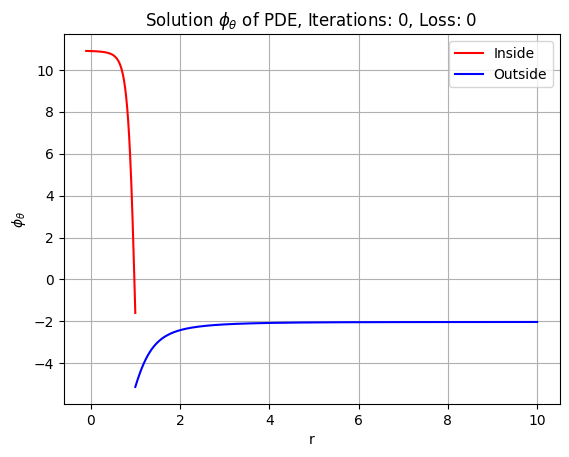

In [27]:
Post.plot_u_plane(theta=np.pi, phi=0)

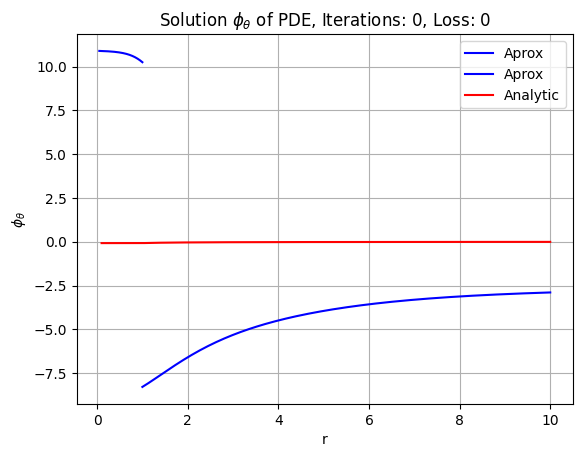

In [28]:
Post.plot_aprox_analytic(theta=np.pi/2, phi=0)